# Theory of Long-Term Stock Forecasting

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/FinanceOps) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmlHaWuVxIA0pKL1yjryR0Z)

## Introduction

The [first paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01_Forecasting_Long-Term_Stock_Returns.ipynb) in this series showed that the long-term return of the S&P 500 stock-market index, as well as some individual stocks, could be predicted quite well from their P/Sales ratios using simple curve-fits on the data. The [second paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb) improved the curve-fits by averaging over all investment periods between 7 and 15 years, which removed a lot of noise from using investment periods of fixed length such as 10 years.

This paper presents the formal theory governing our previous observations, and gives formulas for the mean and standard deviation of the forecasted returns, based on the dividend yield, sales per share growth, and the future distribution of P/Sales ratios.

It is recommended that you are familiar with the previous two papers before reading this.

## Python Imports

This Jupyter Notebook is implemented in Python v. 3.6 and requires various packages for numerical computations and plotting. See the installation instructions in the README-file.

In [1]:
%matplotlib inline

In [2]:
# Imports from Python packages.
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import numpy as np
import os

In [3]:
# Imports from FinanceOps.
from data_keys import *
from data import load_index_data, load_stock_data
from returns import prepare_ann_returns, reinvestment_growth

## Load Data

We now load all the financial data we will be using.

In [4]:
# Define the ticker-names for the stocks we consider.
ticker_SP500 = "S&P 500"
ticker_JNJ = "JNJ"
ticker_K = "K"
ticker_PG = "PG"
ticker_WMT = "WMT"

In [5]:
# Load the financial data for the stocks.
df_SP500 = load_index_data(ticker=ticker_SP500)
df_JNJ = load_stock_data(ticker=ticker_JNJ)
df_K = load_stock_data(ticker=ticker_K)
df_PG = load_stock_data(ticker=ticker_PG)
df_WMT = load_stock_data(ticker=ticker_WMT)

## Mathematical Model

We are interested in finding a mathematical model that accurately describes the behaviour of long-term stock returns. First we define the Total Return of a stock as the number of shares which may grow from reinvestment of dividends, multiplied by the share-price:

$$
Total\ Return_t = Shares_t \cdot Share\ Price_t
$$

The annualized return between the start-date $t$ and the end-date $t+Years$ is then defined as:

$$
Ann\ Return_t
= \left( \frac{Total\ Return_{t+Years}}{Total\ Return_t} \right) ^ {1/Years} - 1
\\
= \left( \frac{Shares_{t+Years} \cdot Share\ Price_{t+Years}}{Shares_t \cdot Share\ Price_t} \right) ^ {1/Years} - 1
$$

We are ultimately interested in finding a formula that allows us to forecast the future return of the stock from a predictor variable such as the P/Sales ratio. We use the P/Sales ratio instead of e.g. the P/Earnings ratio, because the Sales number is typically much more stable than the Earnings number. For most companies the Sales number is also non-zero and positive, which means we can use a small trick to rewrite the share-price, simply by dividing and multiplying by the Sales Per Share:

$$
Share\ Price_t = \frac{Share\ Price_t}{Sales_t} \cdot Sales_t = P/Sales_t \cdot Sales_t
$$

Using this in the formula for the annualized return we get:

$$
Ann\ Return_t = \left( \frac{Shares_{t+Years}}{Shares_t} \cdot \frac{P/Sales_{t+Years}}{P/Sales_t} \cdot \frac{Sales_{t+Years}}{Sales_t} \right) ^ {1/Years} - 1
$$
It is important to note that this formula follows directly from the definition of the annualized return and therefore shows us that the total return on a stock results from the following: (1) The growth in the number of shares from reinvestment of dividends, (2) the change in the P/Sales valuation ratio, and (3) the change in the Sales Per Share. Forecasting the future return on a stock can therefore be split into forecasting these three factors.

### Forecasting the Mean Return

The three factors that determine the future return on a stock are impossible to predict with perfect accuracy. Instead we will use historical data to estimate a distribution of future returns. Let us first consider the average return.

The current values for time-step $t$ are all known: $Shares_t$, $P/Sales_t$ and $Sales_t$, but the future values for time-step $t+Years$ are stochastic variables because they are unknown. So the mean annualized return is:

$$
E[Ann\ Return_t] = E \left[ \left( \frac{Shares_{t+Years}}{Shares_t} \cdot \frac{P/Sales_{t+Years}}{P/Sales_t} \cdot \frac{Sales_{t+Years}}{Sales_t} \right) ^ {1/Years} - 1 \right]
$$

We are interested in finding a formula that allows us to forecast $E[Ann\ Return_t]$ from the current valuation ratio $P/Sales_t$, which is a known value and therefore not stochastic, so it follows from the properties of the mean operator that the formula can be rewritten as:

$$
E[Ann\ Return_t] = \frac{
E \left[ \left( \frac{Shares_{t+Years}}{Shares_t} \cdot \frac{Sales_{t+Years}}{Sales_t} \cdot P/Sales_{t+Years} \right) ^ {1/Years} \right]}
{P/Sales_t ^ {1/Years}} - 1
$$

It is possible to calculate this mean directly using historical data, but for longer investment periods it requires a lot of data. For example, if we only have 15 years of data and we want to know the mean annualized return for 10 year periods, we effectively only have 5 years of starting-dates, which may only cover a small scope of P/Sales ratios. We would also like to rewrite the formula in terms of variables that we can easily interpret and adjust if we believe the future growth-rates may be different from the past.

To do this, we will first assume that the future stochastic variables for $Shares_{t+Years}$, $P/Sales_{t+Years}$ and $Sales_{t+Years}$ are independent of each other and also independent of the current valuation ratio $P/Sales_t$. In reality these may all be dependent, especially in the short term, so the formula we now derive will only be an estimate which may have significant errors. But this is considered acceptable because it results in a simple formula, and we don't know the true distribution of these stochastic variables anyway, as we only have limited historical data which may not be representative of the future.

With this assumption, the formula for the mean annualized return becomes:

$$
E[Ann\ Return_t] = \frac{
E \left[ \left( \frac{Shares_{t+Years}}{Shares_t} \right) ^ {1/Years} \right]
\cdot E \left[ \left( \frac{Sales_{t+Years}}{Sales_t} \right)^ {1/Years} \right]
\cdot E \left[ P/Sales_{t+Years} ^ {1/Years} \right]
}
{P/Sales_t ^ {1/Years}} - 1
$$

Let us discuss these three factors in turn:

* $Shares_{t+Years}$ is the number of future shares that has grown from reinvestment of dividends, so $E[(Shares_{t+Years} / Shares_t)^{1/Years}]$ is the mean annualized growth-rate for all periods of the given number of years. If we assume the dividend is paid out once per year and immediately invested back into buying more shares, then the mean annual growth in the number of shares, is roughly equal to the mean dividend yield, which is defined as the dividend for the trailing year divided by the share-price. So we have:

$$
E \left[ (Shares_{t+Years} / Shares_t)^{1/Years} \right]
\simeq E[Dividend\ Yield + 1]
$$

* $Sales_{t+Years}$ is the future Sales Per Share, so $E[(Sales_{t+Years}/{Sales_t}) ^ {1/Years}]$ is the mean annualized growth-rate for all periods of the given number of years. If we assume that the sales-growth is independent from one year to the next, then we can simply use the one-year sales-growth as an estimate:

$$
E \left[ (Sales_{t+Years}/{Sales_t}) ^ {1/Years} \right]
\simeq E[Sales\ Per\ Share\ Growth + 1]
$$

* $P/Sales_{t+Years}$ is the future valuation ratio. If we assume that it has the same distribution as the historical data, then we will simply write $P/Sales$ without the subscript. Furthermore, if we only know the mean P/Sales ratio but not its distribution, then we can estimate the mean of the exponent by moving the exponent outside of the parentheses, however, this increases the estimation error due to Jensen's Inequality, so it is preferred to calculate the exponent inside the parentheses when possible:

$$
E \left[ P/Sales_{t+Years} ^ {1/Years} \right] = E \left[ P/Sales ^ {1/Years} \right]
\simeq E[ P/Sales ] ^ {1/Years}
$$

Putting all this together, we can estimate the mean annualized return from the current $P/Sales_t$ ratio as follows:

$$
E[Ann\ Return_t] = \frac{a}{P/Sales_t ^ {1/Years}} - 1
$$

where:

$$
a \simeq E[Dividend\ Yield + 1]
\cdot E[Sales\ Per\ Share\ Growth + 1]
\cdot E[ P/Sales ^ {1/Years} ]
$$

We can use the historical means for the dividend yield, sales growth, and P/Sales ratios, or we can use other numbers if we think the future will be different from the past.

### Forecasting the Standard Deviation of the Return

Let us now consider the standard deviation. Using the definition of the annualized return we have:

$$
Std[Ann\ Return_t] = Std \left[ \left( \frac{Shares_{t+Years}}{Shares_t} \cdot \frac{P/Sales_{t+Years}}{P/Sales_t} \cdot \frac{Sales_{t+Years}}{Sales_t} \right) ^ {1/Years} - 1 \right]
$$

Because $P/Sales_t$ is a known number and not a stochastic variable, it follows from the properties of the standard deviation that we can move it outside. Then using similar arguments as above, we can use the dividend yield and one-year sales-growth as estimates for the growth-factors, so we get:

$$
Std[Ann\ Return_t] = \frac{b}{P/Sales_t ^ {1/Years}}
$$

where:

$$
b \simeq Std \left[ (Dividend\ Yield + 1) \cdot (Sales\ Per\ Share\ Growth + 1) \cdot P/Sales ^ {1/Years} \right]
$$

Even if we assume that these stochastic variables are independent, the closed-form formula of this standard deviation is very complicated, so it is much easier to simply do a Monte Carlo simulation for estimating $b$.

### Implementation

This class implements the mathematical model we developed above to forecast long-term stock returns.

In [6]:
class ForecastModel:
    """
    Mathematical model used to forecast long-term stock returns.
    """

    def __init__(self, dividend_yield, sales_growth,
                 psales, years):
        """
        Create a new model and fit it with the given data.
        
        :param dividend_yield: Array with dividend yields.
        :param sales_growth: Array with one-year sales growth.
        :param psales: Array with P/Sales ratios.
        :param years: Number of years.
        """
        
        # Copy args to self.
        # Note the +1 for dividend yield and sales-growth
        # so we don't have to do it several times below.
        self.dividend_yield = np.array(dividend_yield) + 1
        self.sales_growth = np.array(sales_growth) + 1
        self.psales = psales
        self.years = years
        
        # Calculate the `a` parameter for the mean ann.return.
        self.a = self.mean_parameter()

        # Calculate the `b` parameter for the std.dev. ann.return.
        self.b = self.std_parameter()

    def forecast(self, psales_t):
        """
        Use the fitted model to forecast the mean and std.dev.
        for the future stock returns.
        
        :param psales_t: Array with different P/Sales ratios at buy-time.
        :return: Two arrays with mean and std.ann. for the ann. returns
                 for each of the psales_t values.
        """

        # Annualized psales_t which is used in both formulas.
        psales_t_ann = psales_t ** (1/self.years)

        # Forecast the mean and std.dev. for the ann. returns
        # for the different choices of P/Sales ratios at the
        # time of buying the stock.
        mean = self.a / psales_t_ann - 1.0
        std = self.b / psales_t_ann

        return mean, std
    
    def mean_parameter(self):
        """
        Estimate the parameter `a` used in the formula for the
        mean annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        :return: The parameter `a` for the mean return formula.
        """

        # We assume dividend_yield and sales_growth is already +1.
        a = np.mean(self.dividend_yield) \
          * np.mean(self.sales_growth) \
          * np.mean(self.psales ** (1/self.years))

        return a

    def std_parameter(self, num_samples=10000):
        """
        Estimate the parameter `b` used in the formula for the
        std.dev. annualized return, given arrays with distributions
        for the dividend yield, sales-growth and P/Sales.

        This is estimated using Monte Carlo simulation / resampling
        of the given data, which is assumed to be independent of
        each other and over time.

        :param num_samples: Number of Monte Carlo samples.
        :return: The parameter `b` for the std.dev. return formula.
        """

        # We will do a Monte Carlo simulation / resampling
        # from the supplied arrays of data. For each year
        # we take e.g. 10k random samples and then we
        # calculate the annualized growth-rates. This gives
        # us different values for dividend yields and sales-growth
        # for each year, instead of just taking one random
        # number and using that for all the years.

        # Shape of arrays to sample.
        shape = (num_samples, self.years)
        num_samples_total = np.prod(shape)

        # Sample the dividend yield. We assume it is already +1.
        dividend_yield_sample = np.random.choice(self.dividend_yield, size=shape)
        # Compound the growth through the years.
        dividend_yield_sample = np.prod(dividend_yield_sample, axis=1)

        # Sample the sales-growth. We assume it is already +1.
        sales_growth_sample = np.random.choice(self.sales_growth, size=shape)
        # Compound the growth through the years.
        sales_growth_sample = np.prod(sales_growth_sample, axis=1)

        # Sample the P/Sales ratio at the time of selling.
        psales_sample = np.random.choice(self.psales, size=num_samples)

        # Combine the three samples.
        combined_sample = dividend_yield_sample * sales_growth_sample * psales_sample

        # Calculate the `b` parameter.
        b = np.std(combined_sample ** (1/self.years))

        return b

### Return Curves

The formula for the mean annualized return has a characteristic shape. We will now show how it changes with different choices of parameters. We call these for Return Curves.

In [7]:
def plot_return_curves(years, a=1.0):
    """
    Plot the "return curves" for mean annualized return with
    different choices of years:

    ann_ret = a / (P/Sales ^ (1/year)) - 1
    
    :param years: Array of different years to plot.
    :param a: The `a` parameter in the formula above.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Array of values for the x-axis.
    psales = np.linspace(start=0.5, stop=2, num=100)

    # For each year in the given array.
    for year in years:
        # Calculate "return curve" values for the y-axis.
        ann_ret = a / (psales ** (1/year)) - 1.0

        # Set the label for this curve and plot it.
        label = "Year = {0}".format(year)
        ax.plot(psales, ann_ret, label=label)

    # Show the labels for all the curves.
    ax.legend()
    
    # Set the labels for the axes.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda x, _: '{:.0%}'.format(x))
    ax.yaxis.set_major_formatter(formatter)
    
    # Show grid and mark the gain/loss lines.
    ax.grid()
    ax.axhline(0, color='black')
    ax.axvline(1, color='black')
    
    # Show the plot.
    plt.show()

We can now show the shape of the so-called Return Curves. We have set the $a$ parameter to 1 in these plots, so it is easy to see the effect of varying the P/Sales ratio at the buy-time. The $a$ parameter is just a linear scale that moves the curves up or down.

Note the characteristic downwards slope of all the curves, which is because the formula divides with the P/Sales ratio, so the annualized return decreases in a reciprocal manner as the P/Sales increases.

The steepness of the curve is determined by the number of investment years, where the curve becomes more flat as the number of years increases. This is because the revaluation of the P/Sales ratio is spread over more years, so its effect on the annualized return is lower.

Also note that the forecasting model's formula for the standard deviation follows the same type of curves, except they do not subtract 1 as done in this plot for the mean return.

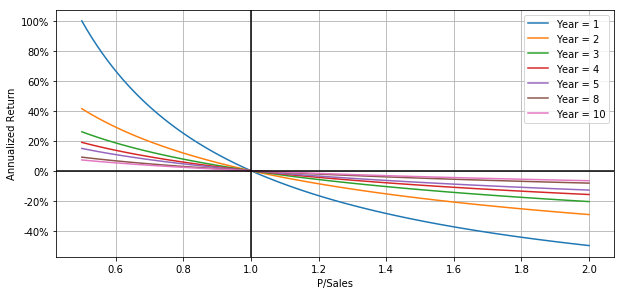

In [8]:
plot_return_curves(years=[1, 2, 3, 4, 5, 8, 10])

## Plotting Function

This is the helper-function for plotting the historical annualized returns and overlay them with the mean and standard deviation of the forecasting model.

In [9]:
def plot_ann_returns(ticker, df, years,
                     dividend_yield=None, sales_growth=None,
                     psales=None,
                     psales_min=None, psales_max=None):
    """
    Create a plot with the actual historical returns showing
    the P/Sales ratios vs. future Annualized Returns. Overlay
    this plot with the estimated mean and std.dev. from the
    mathematical forecasting model we have derived above.
    
    The optional params are taken from the DataFrame `df`
    if not supplied. This allows you to override some or
    all of the data used in the forecasting model e.g.
    to change assumptions about future sales-growth.
    
    :param ticker: String with ticker for the stock or index.
    :param df: Pandas DataFrame.
    :param years: Number of investment years.
    :param dividend_yield: (Optional) Array with dividend yields.
    :param sales_growth: (Optional) Array with one-year sales growth.
    :param psales: (Optional) Array with P/Sales ratios.
    :param psales_min: (Optional) Min P/Sales for plotting curves.
    :param psales_max: (Optional) Max P/Sales for plotting curves.
    :return: None.
    """
    
    # Create a single plot.
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(211)

    # Select only the data we need.
    df2 = df[[TOTAL_RETURN, DIVIDEND_YIELD, SALES_GROWTH, PSALES]]

    # Remove rows for which there is missing data.
    df2 = df2.dropna()

    # Get Dividend Yield if none provided.
    if dividend_yield is None:
        dividend_yield = df2[DIVIDEND_YIELD]

    # Get Sales Growth if none provided.
    if sales_growth is None:
        sales_growth = df2[SALES_GROWTH]

    # Get P/Sales if none provided.
    if psales is None:
        psales = df2[PSALES]

    # Get min P/Sales for plotting if none provided.
    if psales_min is None:
        psales_min = np.min(psales)
    
    # Get max P/Sales for plotting if none provided.
    if psales_max is None:
        psales_max = np.max(psales)
        
    # Create the forecasting model and fit it to the data.
    model = ForecastModel(dividend_yield=dividend_yield,
                          sales_growth=sales_growth,
                          psales=psales, years=years)
    
    # Evenly spaced P/Sales ratios between historic min and max.
    psales_t = np.linspace(start=psales_min, stop=psales_max, num=100)

    # Use the model to forecast the mean and std ann.returns.
    mean, std = model.forecast(psales_t=psales_t)
    
    # Plot the mean ann.return.
    ax.plot(psales_t, mean, color="black", label="Forecast Mean")
    
    # Plot one standard deviation.
    color = "green"
    alpha = 0.3
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-std, color=color,
            label="Forecast Mean $\pm$ 1 Std.Dev.")
    ax.plot(psales_t, mean+std, color=color)
    # Fill the areas.
    ax.fill_between(psales_t, mean+std, mean-std,
                    color=color, edgecolor=color, alpha=alpha)
    
    # Plot two standard deviations.
    color = "red"
    alpha = 0.1
    # Plot lines below and above mean.
    ax.plot(psales_t, mean-2*std, color=color,
            label="Forecast Mean $\pm$ 2 Std.Dev.")
    ax.plot(psales_t, mean+2*std, color=color) 
    # Fill the areas.
    ax.fill_between(psales_t, mean-std, mean-2*std,
                    color=color, edgecolor=color, alpha=alpha)
    ax.fill_between(psales_t, mean+std, mean+2*std,
                    color=color, edgecolor=color, alpha=alpha)

    # Get the actual ann.returns from the historic data.
    x, y = prepare_ann_returns(df=df2, years=years, key=PSALES)

    # Scatter-plot with the actual P/Sales vs. Ann.Returns.
    ax.scatter(x, y, label="Actual Returns")

    # Show the labels for what we have just plotted.
    ax.legend()

    # Create plot-title.
    # First part of the title.
    title1 = "[{0}] {1}-Year Ann. Return".format(ticker, years)
    # Second part of the title. Formula for mean ann. return.
    msg = "E[Ann Return] = {0:.2f} / (P/Sales ^ (1/{1})) - 1"
    title2 = msg.format(model.a, years)
    # Third part of the title. Formula for std.dev. ann. return.
    msg = "Std[Ann Return] = {0:.3f} / (P/Sales ^ (1/{1}))"
    title3 = msg.format(model.b, years)
    # Combine and set the plot-title.
    title = "\n".join([title1, title2, title3])
    ax.set_title(title)

    # Convert y-ticks to percentages.
    formatter = FuncFormatter(lambda y, _: '{:.0%}'.format(y))
    ax.yaxis.set_major_formatter(formatter)

    # Set axes labels.
    ax.set_xlabel("P/Sales")
    ax.set_ylabel("Annualized Return")

    # Show grid.
    ax.grid()
    
    # Show the plot.
    plt.show()

## Case Study: S&P 500

The S&P 500 is a stock-market index consisting of the stocks of 500 of the largest companies in USA. The S&P 500 covers about 80% of the whole U.S. stock-market in terms of size so it is useful as a gauge for the entire U.S. stock-market.

We expect that our forecasting formulas may be particularly suited for a broadly diversified stock-market index such as the S&P 500, because the historical data may be more representative of the future, compared to individual companies whose business fortunes often change dramatically over longer time horizons.

Before we use our forecasting formulas on the historical data, we ought to study that data first, to see if it appears to be somewhat regular, so that our formulas may be used. The formulas use the dividend yield, sales growth, and P/Sales ratio, so we will study those data-sets in turn.

### S&P 500 - Dividend Yield

The following plot shows all the data we have for the dividend yield of the S&P 500 between the years 1950 and 2018. We can see that it has decreased from the early 1950's where it was about 7% down to around 2% in 2018.

But we only have the sales-data for the S&P 500 from the year 1988 onwards. Should we use the dividend yield all the way back from the 1950's and use the sales-data from 1988? We need to be careful here, because there is a subtle but important change that happened from the mid-1990's onwards: A great increase in share buybacks relative to dividend payouts for companies in USA. If we were to use the dividend data between 1950 and 1990 as well, then we would likely overestimate the future dividend yield. So we will only use data for the years where all the necessary data is available.

How share buybacks affect our forecasting formulas are discussed in more detail below.

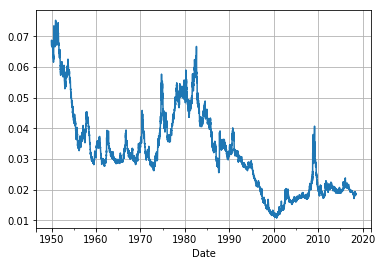

In [10]:
df_SP500[DIVIDEND_YIELD].plot(grid=True)

### S&P 500 - Sales Growth

Let us now consider the one-year sales-growth for the S&P 500. We show both a plot and summary statistics, where we can see that it is not a constant, but it does seem to fluctuate around a mean of about 3.7% per year, instead of trending up- or downwards during this 30-year period. So it seems reasonable to use the historical sales-growth as a probability distribution for the future.

Note that the historical sales-growth seems to be somewhat cyclical with the peaks occurring about every 5 years. For simplicity we will ignore this and assume the future sales-growth is completely random from the historical distribution. This is a reasonable assumption for long-term forecasting of e.g. 10 years or more. But it might be possible to improve on the forecast for shorter periods of only a few years, by using the sales-growth from the last few years to make better forecasts of the near-term sales-growth.

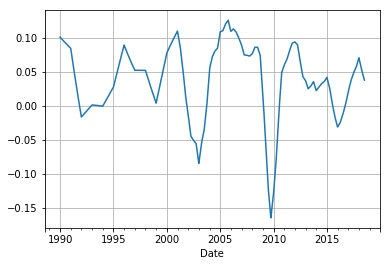

In [11]:
df_SP500[SALES_GROWTH].plot(grid=True)

In [12]:
df_SP500[SALES_GROWTH].describe()

count    10415.000000
mean         0.037141
std          0.053362
min         -0.164586
25%          0.004295
50%          0.043822
75%          0.078067
max          0.125595
Name: Sales Growth, dtype: float64

### S&P 500 - P/Sales

The following plot shows the historical P/Sales ratio which ranged between 0.6 and 2.2. The lowest P/Sales ratios were experienced in 1991 and during the financial crisis around 2009, while the highest P/Sales ratios were experienced in the so-called Dot-Com bubble around year 2000 and towards the end of 2017, which is the end of this data-set.

The historical mean P/Sales ratio was about 1.36 with a standard deviation of about 0.4, so the low and high P/Sales ratios of 0.6 and 2.2 are both about 2 standard deviations from the mean.

There is no guarantee that future P/Sales ratios will remain within this range, but it is almost 30 years of data with several peaks and crashes, so it seems reasonable to use the historical data as a distribution when forecasting future P/Sales ratios.

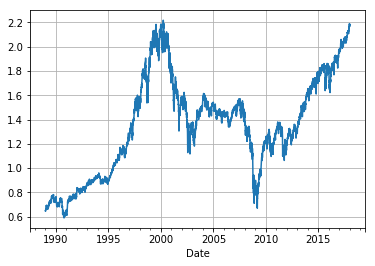

In [13]:
df_SP500[PSALES].plot(grid=True)

In [14]:
df_SP500[PSALES].describe()

count    10591.000000
mean         1.355346
std          0.403827
min          0.590104
25%          1.009636
50%          1.378226
75%          1.618272
max          2.218035
Name: P/Sales, dtype: float64

### S&P 500 - Data Correlations

When deriving the forecasting formulas, we made a number of assumptions about data independence. We now make some scatter-plots to assess whether those assumptions seem reasonable.

First we show the dividend yield versus one-year sales-growth for the S&P 500. The relation is not completely random, but there is no overall trend-line either, so it seems reasonable to sample from the historical data as if these two variables were independent.

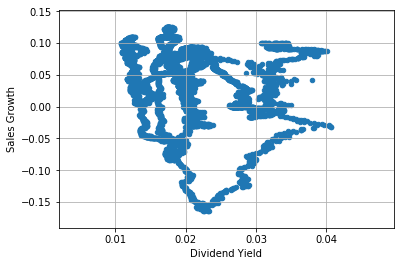

In [15]:
df_SP500.plot(x=DIVIDEND_YIELD, y=SALES_GROWTH,
              kind='scatter', grid=True)

The same can be said about the P/Sales ratio versus the one-year sales-growth, so it also seems reasonable to sample as if the two variables were independent.

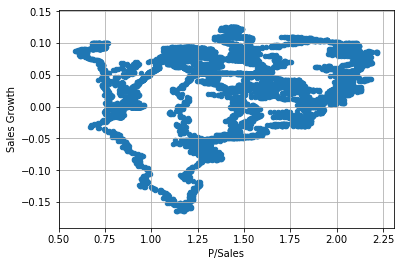

In [16]:
df_SP500.plot(x=PSALES, y=SALES_GROWTH, kind='scatter', grid=True)

Now consider the P/Sales ratio versus the dividend yield where there is a strong relation. This is natural because the dividend yield is defined as the dividend for the trailing 12 months divided by the current share-price, and the dividend is closely related to the sales-per-share, as shown by the following plots.

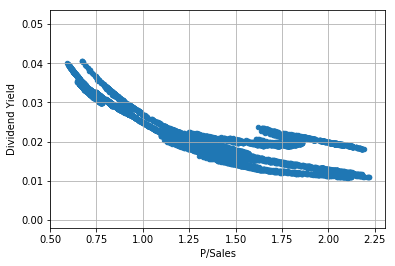

In [17]:
df_SP500.plot(x=PSALES, y=DIVIDEND_YIELD, kind='scatter', grid=True)

We can also show the sales per share versus the dividend.

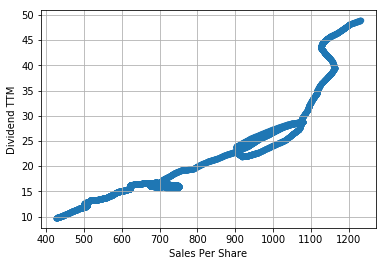

In [18]:
df_SP500.plot(x=SALES_PER_SHARE, y=DIVIDEND_TTM,
              kind='scatter', grid=True)

We can also show the dividend as a fraction of the sales per share, which ranges between 2-4% for this 30-year period.

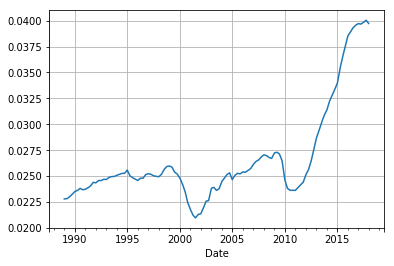

In [19]:
(df_SP500[DIVIDEND_TTM] / df_SP500[SALES_PER_SHARE]).plot(grid=True)

### S&P 500 - 1 Year Returns

We can now use the forecasting model on the historical data for the S&P 500. The plot shows the actual one-year returns of the S&P 500 as blue dots. The forecasted mean return is the black line. The green area is one standard deviation around the mean, and the red area is two standard deviations.

Several things should be noted here. First, note how the forecasted returns have very high uncertainty as measured by the standard deviation. This is to be expected because the model makes its forecast solely from the P/Sales ratio which is a weak predictor in the short-term. Second, note how the forecast uncertainty is much higher for lower P/Sales ratios, which follows from the shape of the Return Curves, as shown above. Third, note how the forecasted return fits around the actual historical returns of the S&P 500, which are mostly contained within 2 standard deviations of the mean.

Overall, the model does not seem to be very useful at forecasting one-year returns of the S&P 500. Perhaps the forecast could be improved if we make better short-term forecasts for the dividend yield, sales-growth and changes in the P/Sales ratio, using conditional probabilities. But that would be a topic for future research.

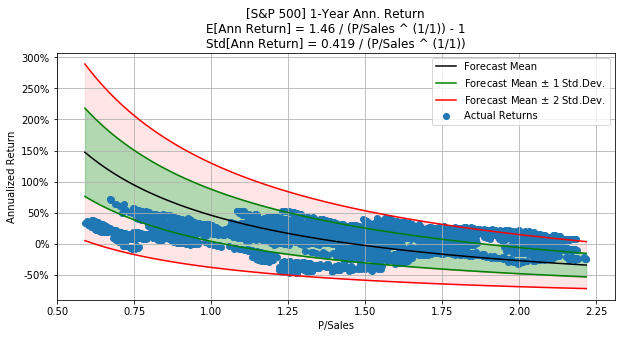

In [20]:
plot_ann_returns(years=1, ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 2 Year Returns

This plot shows the forecasted returns compared to the S&P 500's actual returns for 2-year investment periods. Here we start to see more of a downward slope similar to the model's return curves, although the uncertainty is still very high.

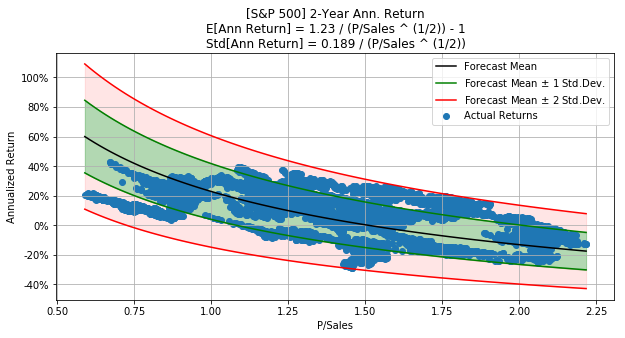

In [21]:
plot_ann_returns(years=2, ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 3 Year Returns

For 3-year investment periods the actual returns of the S&P 500 become a little more centered around the mean forecasted return.

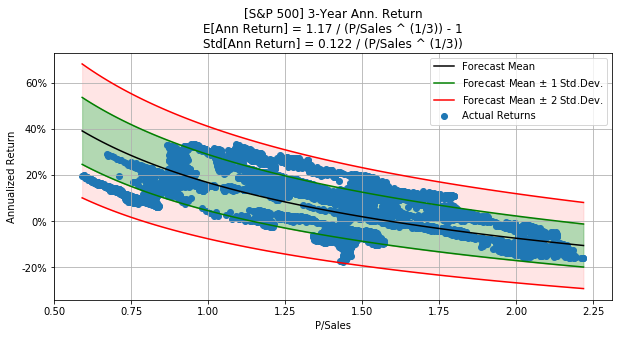

In [22]:
plot_ann_returns(years=3, ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 5 Year Returns

For 5-year investment periods the actual returns of the S&P 500 are mostly within one standard deviation of the forecasted mean.

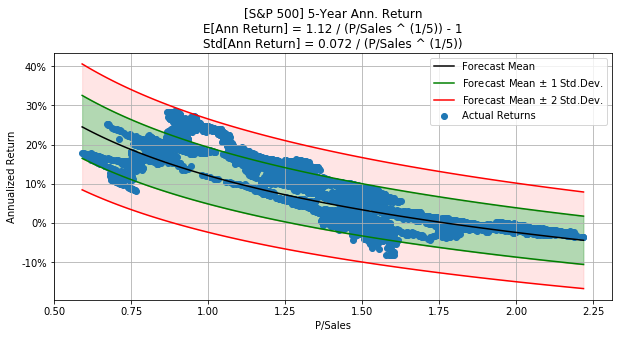

In [23]:
plot_ann_returns(years=5, ticker=ticker_SP500, df=df_SP500)

### S&P 500 - 10 Year Returns

For 10-year investment periods, the actual returns of the S&P 500 are almost all within one standard deviation of the forecasted mean, but there are two periods with significant outliers, as shown in the following plot.

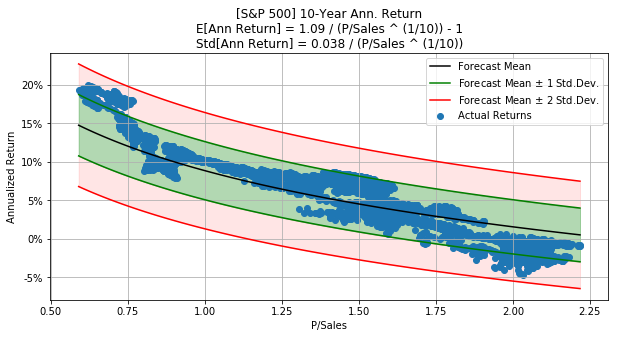

In [24]:
plot_ann_returns(years=10, ticker=ticker_SP500, df=df_SP500)

The first outlier is for P/Sales ratios around 0.7, which is most likely for the period between 1990-2000, where the P/Sales ratio started around 0.7 in the year 1990 and ended at 2.2 in 2000, see the plot below. So there was a very unusual and dramatic expansion of the P/Sales valuation ratio during this 10-year period.

The second outlier is for P/Sales ratios around 2, which most likely corresponds to the period between 1999 and 2009, which started near the peak of the Dot-Com bubble where the P/Sales ratio was 2, and then ended 10 years later in the financial crisis where the P/Sales ratio was only 0.7. This was another unusual 10-year period which went from extreme over-valuation to extreme under-valuation.

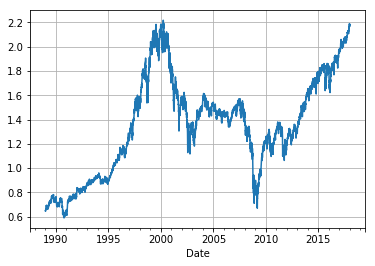

In [25]:
df_SP500[PSALES].plot(grid=True)

It may be possible to fit a curve to the above scatter-plot for 10-year returns of the S&P 500, which fits the historical data better than our forecasting model. This raises the question, whether we should use our forecasting model or some better curve-fit? The answer is that we should use our forecasting model, because it gives a good theoretical explanation for the observed returns, and the outliers that we observed in the historical returns are caused by very unusual periods of over- and under-valuation for the S&P 500, which just happened to occur 10 years apart. Using a fitted curve would essentially be overfitting to the historical data. Using the theoretical forecasting model we get a more accurate estimate of the mean and standard deviation for future returns - provided we use accurate distributions for the future dividend yield, sales growth, and P/Sales ratios.

## Data for the Dividend Yield

The data-set we use here does not include the dividend for individual stocks, which is needed in the forecasting formulas. However, the original forecasting formulas actually did not use the dividend yield, but instead used the growth in the number of shares from reinvestment of the dividend, which we merely approximated with the dividend yield, because it is typically more convenient to work with.

The data-set we use here includes both the share-price and the Total Return for the individual stocks, so we can easily calculate the part of the Total Return that comes from reinvestment of dividends using a small helper-function.

Because the other functions assume this data is stored in a column named `DIVIDEND_YIELD`, we add such a column to the data for the individual stocks.

In [26]:
df_JNJ[DIVIDEND_YIELD] = reinvestment_growth(df_JNJ)
df_K[DIVIDEND_YIELD] = reinvestment_growth(df_K)
df_PG[DIVIDEND_YIELD] = reinvestment_growth(df_PG)
df_WMT[DIVIDEND_YIELD] = reinvestment_growth(df_WMT)

## Case Study: Procter & Gamble (PG)

Let us now consider an individual company called Procter & Gamble which has the ticker symbol PG. It sells a wide range of consumer products and has almost 100.000 employees.

Before we use the forecasting formulas, let us first study the company's historical data.

### PG - Dividend Yield

The following plot shows the dividend yield for the PG stock between 1970 and 2018. The data looks very strange between 1985 and 1992, where the dividend yield even goes beyond 140% which is absurd, because it would mean that you could buy the stock on margin and pay for it entirely from the dividend and make an additional 40% profit.

It is unclear exactly what the problem is. It is either an error in the function `reinvestment_growth()` we use to estimate the dividend yield, or it is a problem in the data which originates from Yahoo Finance. This problem is also observed for the other stocks, although for different time-periods. I have manually checked the data for Wal-Mart against the data in the annual reports, and it appears to be a problem with the data from Yahoo Finance, possibly related to older stock-splits.

For the PG stock, however, we only have sales-data from around 1994, so we won't be using the problematic period of dividend data anyway, and will therefore ignore it here.

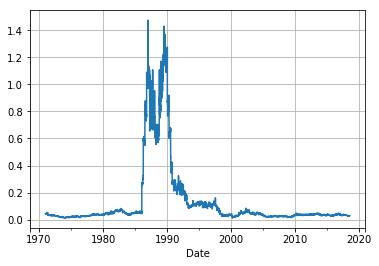

In [27]:
df_PG[DIVIDEND_YIELD].plot(grid=True)

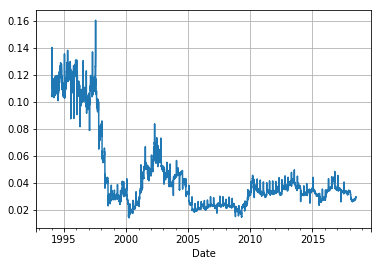

In [28]:
df_PG[DIVIDEND_YIELD]['1994':].plot(grid=True)

### PG - Sales Growth

This plot shows the one-year growth in sales per share for the PG stock, followed by the summary statistics. The mean sales-growth was 3.7% with a standard deviation of 6.0%. There is no clear trend and this looks like it may be a mean-reverting time-series, which therefore seems reasonable to use as a probability distribution for future sales-growth.

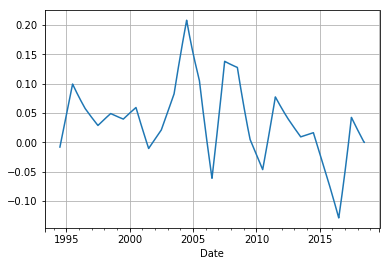

In [29]:
df_PG[SALES_GROWTH].plot(grid=True)

In [30]:
df_PG[SALES_GROWTH].describe()

count    8773.000000
mean        0.036926
std         0.060358
min        -0.128874
25%         0.006407
50%         0.037426
75%         0.063737
max         0.208162
Name: Sales Growth, dtype: float64

### PG - P/Sales

This plot shows the historical P/Sales ratio for the PG stock, which ranged between 1.0 and 4.0 with a mean of 2.5 and standard deviation of 0.6.

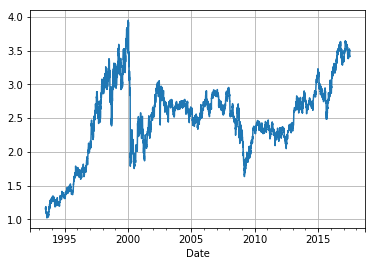

In [31]:
df_PG[PSALES].plot(grid=True)

In [32]:
df_PG[PSALES].describe()

count    8767.000000
mean        2.488695
std         0.566781
min         1.020257
25%         2.245938
50%         2.582562
75%         2.829452
max         3.951821
Name: P/Sales, dtype: float64

### PG - 2 Year Returns

This plot shows the actual returns of the PG stock for all 2-year periods between 1994 and 2017, which mostly fit within 1 standard deviation of the forecasted mean, which is a really good fit for such a short investment period.

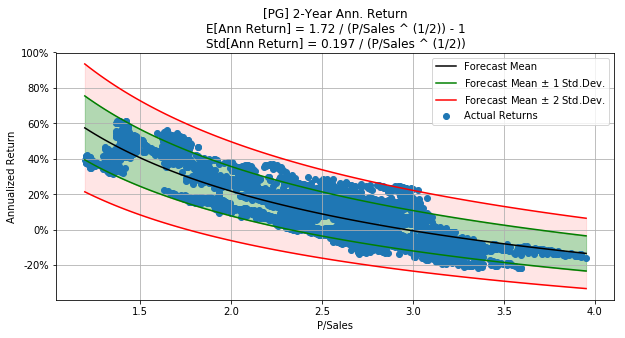

In [33]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=2)

### PG - 5 Year Returns

This plot shows the actual returns of the PG stock for all 5-year periods, which also mostly fit within 1 standard deviation of the forecasted mean.

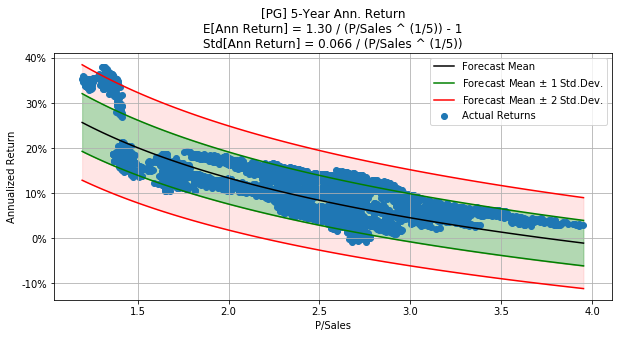

In [34]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=5)

### PG - 10 Year Returns

This plot shows the actual returns of the PG stock for all 10-year periods, which also mostly fit within 1 standard deviation of the forecasted mean.

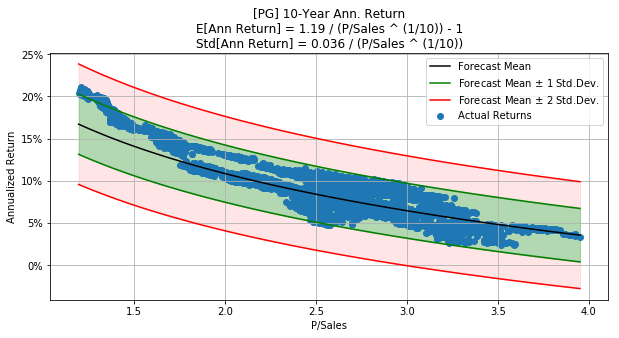

In [35]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=10)

### PG - 15 Year Returns

This plot shows the actual returns of the PG stock for all 15-year periods, which fit quite well around the forecasted mean.

Note that this data only covers the period between 1994 and 2017, so the start-dates for all 15-year periods only range between 1994 and 2002, which does have the entire P/Sales range (see the P/Sales plot above), but the end-dates are between 2009 and 2017 which have a more narrow range of P/Sales ratios. So the selling P/Sales ratios have lower variance than the buying P/Sales ratios. That may explain why the actual returns fit much tighter around the forecasted mean and standard deviation.

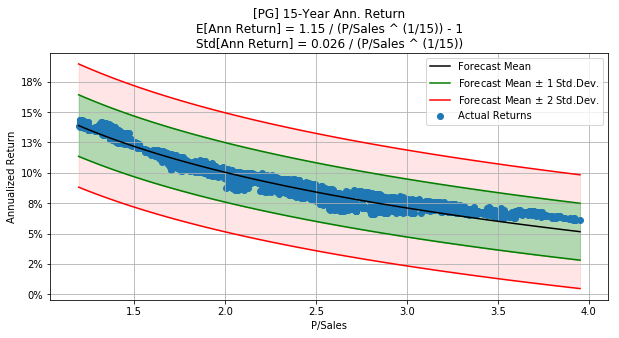

In [36]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=15)

### PG - 20 Year Returns

This plot shows the actual returns of the PG stock for all 20-year periods with start-dates between 1994 and 1997, and end-dates between 2014 and 2017.

Because the forecasting model uses data for individual years, it can easily be used for very long-term forecasts, even if we have little or no data for such long investment periods.

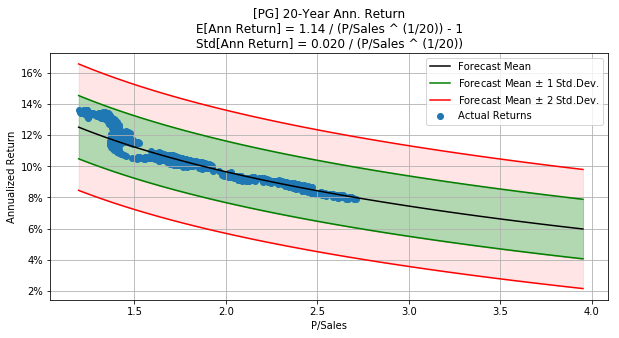

In [37]:
plot_ann_returns(df=df_PG, ticker=ticker_PG, years=20)

## Case Study: Wal-Mart (WMT)

Now let us consider the company Wal-Mart which trades under the ticker symbol WMT. It is an extremely large retail-company with about 2.3 million employees.

Before we use the forecasting formulas, let us first study the company's historical data.

### WMT - Dividend Yield

The following plot shows the estimated dividend yield for the WMT stock between 1972 and 2018, where we can see a very strange spike between 1985 and 1990. As explained above, I have manually compared this to the annual reports of the company, and this spike seems to be an error in the data obtained from Yahoo Finance, possibly due to stock-splits not being adjusted properly for that period.

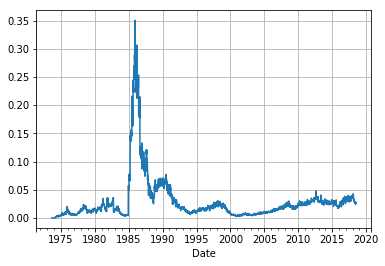

In [38]:
df_WMT[DIVIDEND_YIELD].plot(grid=True)

### WMT - Sales Growth

The following plot shows the one-year growth in sales per share for the WMT stock. As can be seen, it starts at about 40% sales-growth per year in 1972 and decreases to 0% in 2018. So the company had explosive sales-growth that gradually decreased.

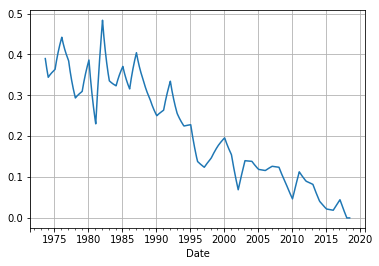

In [39]:
df_WMT[SALES_GROWTH].plot(grid=True)

The above plot is somewhat irregular, so we can also plot the rolling average of 10 year sales-growth. This shows a very smooth downward-sloping curve, with the sales-growth gradually decreasing as the company becomes larger and its growth-opportunities wane.

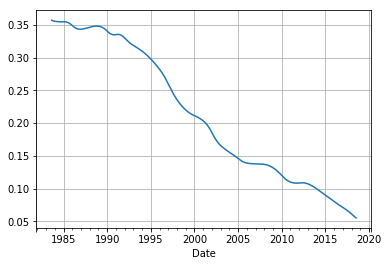

In [40]:
df_WMT[SALES_GROWTH].rolling(window=10*365).mean().plot(grid=True)

### WMT - P/Sales

The following plot shows the historical P/Sales ratios. It ranges roughly between 0.25 and 2.0, with a mean of 0.8 and standard deviation of 0.35.

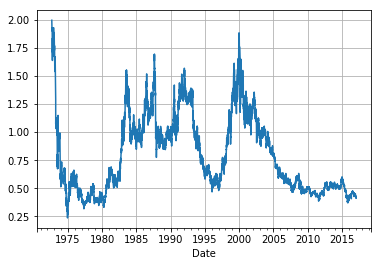

In [41]:
df_WMT[PSALES].plot(grid=True)

In [42]:
df_WMT[PSALES].describe()

count    16231.000000
mean         0.796723
std          0.345737
min          0.235894
25%          0.508904
50%          0.661773
75%          1.035299
max          1.997096
Name: P/Sales, dtype: float64

### WMT - Forecast for Full Period 1972 - 2017

Let us first try and use the forecasting model for the entire period between 1972 and 2017. As we can see from the plot below, the model fits the historical data quite poorly.

Apart from the possible data-errors discussed above, the reason is probably that we assume the dividend yield and growth in sales per share is independent from year to year, so they were randomly sampled when estimating the mean and standard deviation for the return. This assumption does not hold for this particular company, because it started with explosive sales-growth of about 40% per year, which gradually decreased to 0% towards the end of this period. Because our model does not take into account this gradual decrease in sales-growth, the model merely forecasts an average sales-growth for the entire period.

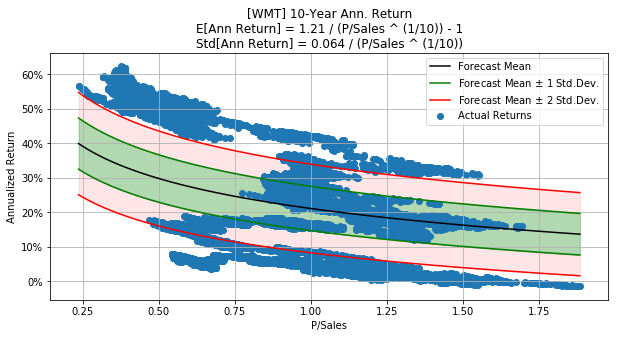

In [43]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT, years=10)

We can also print the summary statistics for the dividend yield and growth in sales per share. Note that the sales growth is much higher than the dividend yield, which means that it contributes much more to the Total Return on the stock during this period. Also note that the sales growth's standard deviation is very high relative to its mean, due to the gradual decrease from about 40% sales growth down to 0%.

In [44]:
df_WMT[[DIVIDEND_YIELD, SALES_GROWTH]].describe()

,Dividend Yield,Sales Growth
count,16387.000000,16387.000000
mean,0.028131,0.210516
std,0.039779,0.124548
min,-0.000031,0.000000
25%,0.009736,0.111957
50%,0.017855,0.187944
75%,0.027785,0.327615
max,0.350602,0.483538


### WMT - Forecast for Early Period 1972-1995

Let us now try and split the data-period roughly in half. First we consider the period between 1972 and 1995. We can see that the forecasting model fits much better now, although still not perfectly.

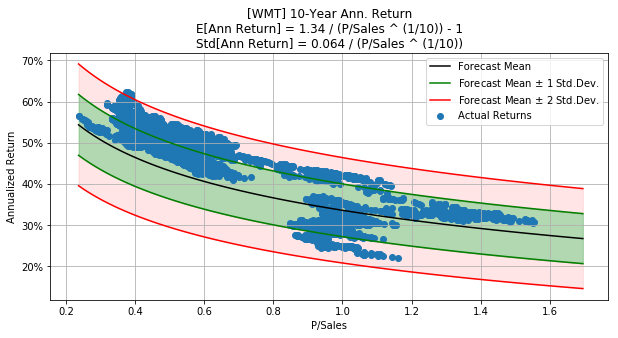

In [45]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT[:'1995'], years=10)

The summary statistics for the dividend yield and sales growth in this period, show that the mean sales growth is about 32% per year with a fairly low standard deviation of about 6%. That probably explains why the forecasting model fits much better now. But the sales growth does decrease from 48% down to only 14% per year during this period, which probably explains why the forecasting model does not fit perfectly, because it merely forecasts an average sales growth.

In [46]:
df_WMT[:'1995'][[DIVIDEND_YIELD, SALES_GROWTH]].describe()

,Dividend Yield,Sales Growth
count,8164.000000,8164.000000
mean,0.037613,0.321931
std,0.053956,0.062802
min,-0.000031,0.144496
25%,0.009510,0.275877
50%,0.016037,0.327810
75%,0.045679,0.362675
max,0.350602,0.483538


### WMT - Forecast for Late Period 1995-2017

Now consider the period between 1995 and 2017. This also fits the historical data much better, although the mean forecast appears to be about 2.5% too high. Once again, it is probably because the forecasting model does not take into account the gradual decrease in sales growth, but merely forecasts an average sales growth.

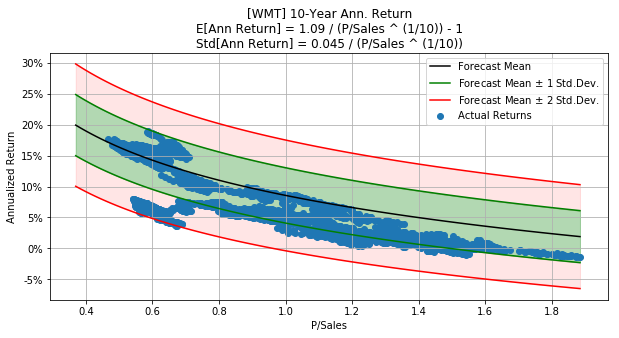

In [47]:
plot_ann_returns(ticker=ticker_WMT, df=df_WMT['1995':], years=10)

In [48]:
df_WMT['1995':][[DIVIDEND_YIELD, SALES_GROWTH]].describe()

,Dividend Yield,Sales Growth
count,8588.000000,8588.000000
mean,0.018555,0.103613
std,0.009072,0.051693
min,0.002519,0.000000
25%,0.010223,0.066301
50%,0.019086,0.116494
75%,0.025280,0.137071
max,0.047912,0.227986


## P/Earnings

We are using the P/Sales ratio in the forecasting model because it is usually more stable than the P/Earnings ratio (P/E for short). 

A company's profit margin is not constant and may fluctuate significantly from one year to the next, sometimes because the company's sales are varying relative to more fixed operating costs, but it can also be due to accounting charges that do not affect the company's cash-flows at all, such as goodwill impairments. The earnings can also become zero in which case the P/E ratio would be infinite, or the company could experience losses in which case the P/E ratio would be negative. So the raw P/E ratio may be distorted in several ways.

A common solution is to use the average earnings for several prior years when calculating the P/E ratio, so as to smoothen out the variations in the profit margin, and hence give a more accurate gauge of how the company's shares are currently priced relative to its average earning-power.

We avoid all these problems when using the P/Sales ratio instead of the P/E ratio. However, the P/Sales ratio can be difficult to interpret, because companies have different profit margins, so they generally trade at different P/Sales levels, which may be difficult to compare directly across companies.

We will now show how to use the forecasting model with a distribution of future P/E ratios and profit margins, which may be useful e.g. when creating a forecasting model from only a small amount of data.

### Case Study: Procter & Gamble (PG)

This plot shows the P/E ratio for the PG stock between 1993 and 2017. This clearly shows the problem of negative and zero earnings, which creates extreme spikes in the P/E ratio.

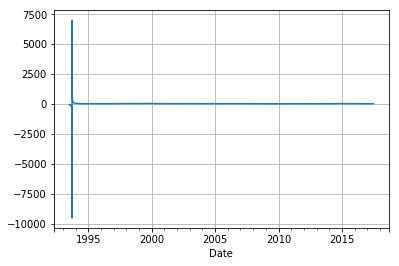

In [49]:
df_PG[PE].plot(grid=True)

The following plot shows that the Earnings Per Share was negative at the beginning of this period, which caused the spikes in the P/E ratio when the Earnings cross zero.

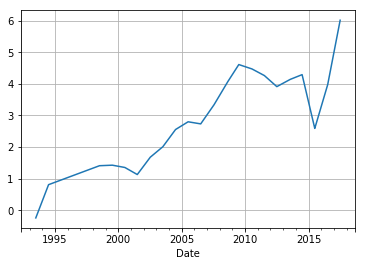

In [50]:
df_PG[EARNINGS_PER_SHARE].plot(grid=True)

Let us instead plot the P/E ratio from 1995 onwards, which ranged roughly between 10 and 40, with an average of 22 and a standard deviation of nearly 6.

In [51]:
start = '1995'

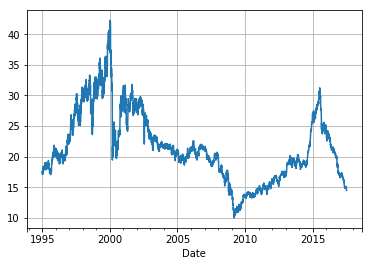

In [52]:
df_PG[PE][start:].plot(grid=True)

In [53]:
df_PG[PE][start:].describe()

count    8217.000000
mean       21.604934
std         5.712537
min        10.006888
25%        17.672594
50%        20.606929
75%        25.222980
max        42.273851
Name: P/E, dtype: float64

We can also show the P/Sales ratio for the same period, which roughly follows the same ups and downs as the P/E ratio.

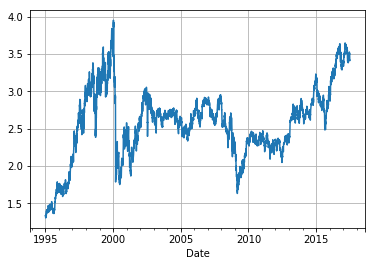

In [54]:
df_PG[PSALES][start:].plot(grid=True)

We can also make a scatter-plot of the P/E versus P/Sales ratios, which shows that they are closely related and generally change together, but they are not perfectly correlated due to the varying profit margins which affect the P/E ratios.

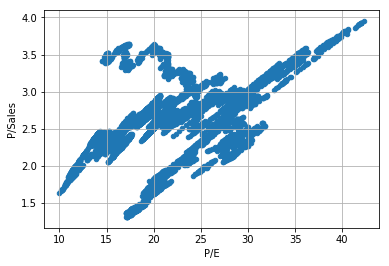

In [55]:
df_PG[start:].plot(x=PE, y=PSALES, kind='scatter', grid=True)

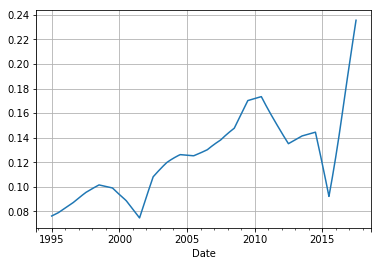

In [56]:
df_PG[PROFIT_MARGIN][start:].plot(grid=True)

### Synthesizing P/Sales Data

Let us now pretend that we want to use the forecasting model but we do not have any historical P/Sales data, e.g. because we are trying to value an IPO (Initial Public Offering). Instead of making up a range of P/Sales ratios, we feel more comfortable making up a range of plausible P/E ratios and profit margins that the company may have in the future, based on our experience with similar companies and stock valuation in general.

The forecasting model will still take a P/Sales ratio as the predictor variable, because it is more stable than P/E ratios, so we expect it to work better. We therefore need a way to convert our distributions of P/E ratios and profit margins to a distribution of P/Sales ratios.

This is the definition of sales, profit margin and earnings:

$$
Sales \cdot Profit\ Margin = Earnings
$$

Assuming all these are non-zero we can rewrite the equation to:

$$
P/Sales = P/E \cdot Profit\ Margin
$$

We then make a small helper-function to implement resampling with this simple formula:

In [57]:
def synthesize_psales(pearnings, profit_margin, num_samples=10000):
    """
    Convert probability distributions for P/E and profit margins
    into a distribution for the P/Sales ratio.
    
    Assume the P/E and profit margins are independent.
    
    :param pearnings: Array of possible P/E ratios.
    :param profit_margin: Array of possible profit margins.
    :param num_samples: Number of random samples.
    :return: Array of possible P/Sales ratios.
    """
    
    # Random samples from the P/E and profit margin distributions.
    # Assume independence of P/E and profit margins.
    pearnings_sample = np.random.choice(pearnings, size=num_samples)
    profit_margin_sample = np.random.choice(profit_margin, size=num_samples)

    # Create the P/Sales sample distribution.
    psales_synth = pearnings_sample * profit_margin_sample
    
    # Convert to Pandas Series.
    psales_synth = pd.Series(psales_synth)
    
    return psales_synth

The above function assumes independence of the P/E ratios and profit margins, which is not generally true as shown in the following plot, although the relation is complicated.

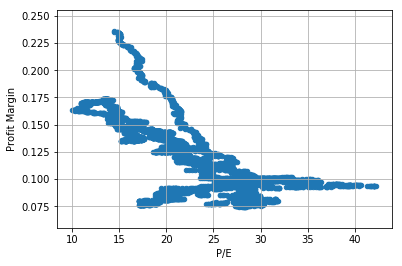

In [58]:
df_PG[start:].plot(x=PE, y=PROFIT_MARGIN, kind='scatter', grid=True)

We will ignore this dependence and simply use the historical P/E ratios and profit margins as if they were independent.

In [59]:
# Get the historical P/E and profit margins.
pearnings = df_PG[PE][start:].dropna()
profit_margin = df_PG[PROFIT_MARGIN][start:].dropna()

# Synthesize the P/Sales ratios from the P/E and profit margins.
psales_synth = synthesize_psales(pearnings=pearnings,
                                 profit_margin=profit_margin)

In [60]:
def compare_psales(synth, hist):
    """
    Helper-function for pretty comparison of statistics
    for synthesized and historical data by putting it into a
    Pandas DataFrame.
    
    :param synth: Array with synthesized data.
    :param hist: Array with historical data.
    :return: Pandas DataFrame.
    """
    data = \
    {
        "Synth": synth.describe(),
        "Hist": hist.describe()
    }
    return pd.DataFrame(data)

Let us now compare the summary statistics for the synthesized and historical P/Sales ratios. This shows the synthesized P/Sales data has nearly the same mean around 2.7 compared to 2.6 for the historical data. But the synthesized P/Sales data has a much higher standard deviation, with much wider min and max values.

The reason for this is that we assumed the distributions for P/E and profit margins were independent when resampling them.

In [61]:
# Pretty comparison.
psales_hist = df_PG[PSALES][start:]
compare_psales(synth=psales_synth, hist=psales_hist)

,Synth,Hist
count,10000.000000,8217.000000
mean,2.687425,2.571894
std,0.986435,0.481508
min,0.847362,1.306146
25%,1.939678,2.317227
50%,2.534334,2.621037
75%,3.228118,2.848265
max,8.271928,3.951821


We can also plot histograms for the synthesized and historical P/Sales data.

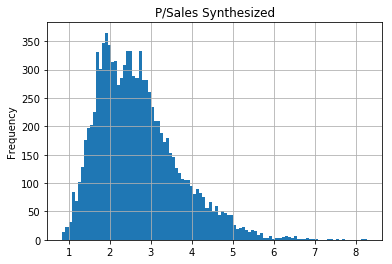

In [62]:
psales_synth.plot(kind='hist', bins=100, grid=True,
                  title="P/Sales Synthesized")

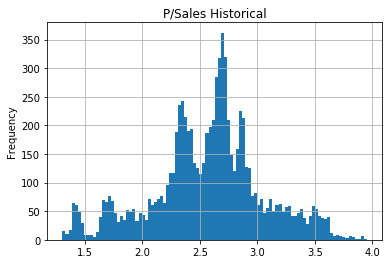

In [63]:
psales_hist.plot(kind='hist', bins=100, grid=True,
                  title="P/Sales Historical")

### Forecasted Returns

We can now use the synthesized P/Sales data when plotting the forecasted returns for the PG stock. Compare this to the plot further above which used historical P/Sales data. We now have slightly higher mean, and a significantly higher standard deviation for the forecasted return, because the synthesized P/Sales ratios have a higher standard deviation than the historical data, due to our assumption that the profit margins and P/E ratios were independent.

Note that we still use the P/Sales ratio as the predictor variable, because it is more stable than the P/E ratio, as explained above.

In [64]:
# Get the historical dividend yield and sales growth.
dividend_yield = df_PG[DIVIDEND_YIELD][start:]
sales_growth = df_PG[SALES_GROWTH][start:]

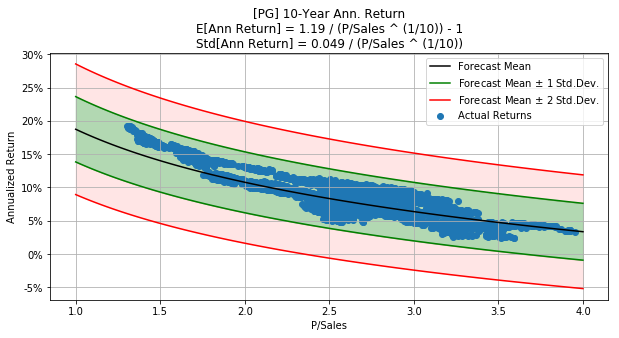

In [65]:
plot_ann_returns(ticker=ticker_PG, df=df_PG[start:], years=10,
                 dividend_yield=dividend_yield,
                 sales_growth=sales_growth,
                 psales=psales_synth, psales_min=1, psales_max=4)

### Small Distributions

If you are trying to value a company with little or no historical data, you may want to use small distributions for the P/E ratios and profit margins. These distributions are chosen approximately to give the same range and mean as the historical data for the PG stock.

In [66]:
# Small distributions for P/E and profit margins.
pearnings = [10, 15, 20, 22, 40]
profit_margin = [0.08, 0.10, 0.12, 0.20]

# Synthesize the P/Sales ratios from the P/E and profit margins.
psales_synth = synthesize_psales(pearnings=pearnings,
                                 profit_margin=profit_margin,
                                 num_samples=1000)

Comparing the synthesized P/Sales ratios to the historical data, we see that the mean is almost the same but the standard deviation is much higher, and the min / max are wider.

In [67]:
# Pretty comparison.
compare_psales(synth=psales_synth, hist=psales_hist)

,Synth,Hist
count,1000.000000,8217.000000
mean,2.715720,2.571894
std,1.737441,0.481508
min,0.800000,1.306146
25%,1.500000,2.317227
50%,2.200000,2.621037
75%,4.000000,2.848265
max,8.000000,3.951821


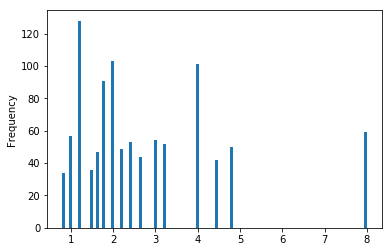

In [68]:
psales_synth.plot(kind='hist', bins=100)

We can use this synthesized P/Sales data in the forecasting model, which results in a correspondingly higher standard deviation for the forecasted returns. If you want a tighter fit, then you must provide better P/E and profit margin distributions, and possibly also model their mutual dependency when resampling the data - although it may then be easier to just provide a better P/Sales distribution.

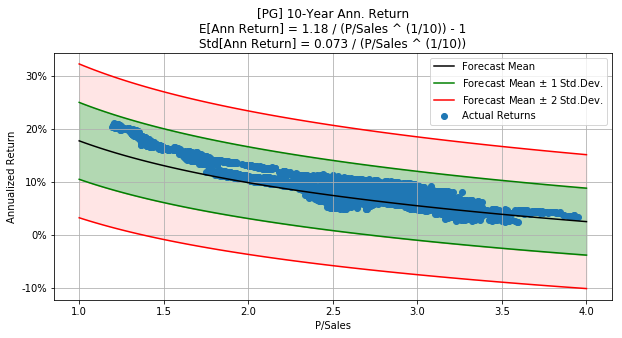

In [69]:
plot_ann_returns(ticker=ticker_PG, df=df_PG, years=10,
                 dividend_yield=dividend_yield,
                 sales_growth=sales_growth,
                 psales=psales_synth, psales_min=1, psales_max=4)

## Discussion

### Other Predictor Variables

We have already discussed the use of P/Earnings instead of P/Sales as the input variable to the forecasting model, and we prefer to use P/Sales because it is generally more stable than P/Earnings.

If you want to use other predictor variables X for gauging the mispricing of a stock using the P/X ratio, it is important that X has a **causal** effect on the future share-price. It is not enough that there is a historical correlation, as that may not continue in the future.

### Share Buybacks vs. Dividends

The forecasting model uses dividend payouts, but share buybacks are now significantly greater than dividends in USA. How does that affect the forecasting model? The short answer is that it doesn't, provided we select the data correctly.

We are forecasting the Total Return, which assumes dividends are reinvested immediately when they are paid out, and that there are no taxes. So our proportion of the outstanding shares is increased according to the dividend and the share-price at that day. If instead the company had used some or all of that dividend money for a share buyback, and assuming this did not move the share-price in any way, then the effect would be an identical decrease in the number of shares following the buyback. So there is no difference in the Total Return from a dividend payout and a share buyback.

In the forecasting model we typically use a historical distribution for the dividend yield. If the company then stops making dividend payouts and starts making share buybacks instead, then the contribution to the Total Return is simply moved from the dividend yield to the Sales Per Share instead, because the number of outstanding shares decreases from the buyback, so the Sales Per Share merely grows by a corresponding amount. The effect on Total Return should be identical.

However, it is important that the data is selected correctly. The data for the dividend yield and Sales Per Share must be selected from the same period in time, so we do not overestimate the future dividend yield relative to growth in Sales Per Share from share buybacks.

For example, for the S&P 500 we have data for the dividend yield from the 1950's onwards, while we only have sales-data from 1988 onwards. During the 1990's companies in USA started shifting alot of their dividend payouts to share buybacks. We therefore need to use both dividend and Sales Per Share data from 1988 onwards, so their contribution to Total Return is mutually consistent. We cannot use the dividend-data between 1950 and 1988 to estimate the future dividend yield, because it would then be overestimated relative to the effect of share buybacks on the Sales Per Share from 1988 onwards, if companies continue to buyback alot of shares.

#### Share Buyback Valuation

Although the Total Return is identical for share buybacks and dividend payouts, it does not mean that a company should automatically buy back shares. Just as reinvestment of dividends is optional for the individual investor, a share buyback is optional for the company's management. If you trust the forecasting models we have developed here, you would be foolish to reinvest your dividend if the forecasted return on the stock is very low or perhaps even negative, because the P/Sales ratio is currently so high. You would either invest the dividend elsewhere or simply keep the cash. Similarly, the company would be foolish to buy back its shares when the share-price is very high and the forecasted returns are very low. In that case the company should just make a dividend payout and let investors decide what to do with the money, or the company can keep the cash for other opportunities in the future. See my [treatise](https://ssrn.com/abstract=2210734) for an extensive theory on share buyback valuation.

## Conclusion

We have presented formulas that forecast the mean and standard deviation of the annualized return of a stock or stock-market index using a valuation ratio such as the P/Sales ratio. The formulas were derived from the definition of the annualized return and therefore show the inherent relation between valuation ratios and stock-returns. The formulas use two parameters that can be estimated from the stock's dividend yield, sales per share growth, and P/Sales ratios.

We also plotted the model's forecasted returns as a function of varying P/Sales ratios. The plotted curves have a characteristic downward slope that follows directly from the mathematical definition of annualized return. We call these for Return Curves and they once again show the inherent relation between valuation ratios such as the P/Sales ratio and future stock-returns, namely that higher valuation ratios lead to lower future returns.

We have tested the forecasting model with historical data for the S&P 500 index and a few individual stocks. The model fitted the historical data very well, provided the distributions for the dividend yield, sales per share growth, and P/Sales ratios were representative for the period that was being forecasted. The model is therefore best used for companies or stock-indices whose future dividend yield, sales per share growth, and P/Sales ratios are similar to their past, or can be predicted somewhat accurately.

## Research Ideas

You are strongly encouraged to do more research on this topic. If you make any new discoveries then please let me know your results. 

To my knowledge, there are no academic studies of predicting the long-term returns of stocks and stock-markets as we have done here. This work has presented the basic idea and methodology, but a lot more research can be done on this subject and it may impact many areas of both theoretical and applied finance.

Here are a few more research ideas to get you started:

- Find the parameters $a$ and $b$ by curve-fitting the scatter-plot with the historical returns. What are the pro's and con's of doing this compared to the method above?

- Derive the closed-form of the $b$ parameter in the forecasting model.

- How large are the estimation errors when using the dividend yield and one-year sales-growth to estimate the $a$ and $b$ parameters?

- Use the return averaging from the [previous paper](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb) in the scatter-plots. How does the forecasting model fit this data? Can you quantify how many years we should average across, in order to halven the standard deviation? What does this mean for investors?

- Change the implementation in `ForecastModel` to use probabilities for the dividend yield, sales growth and P/Sales arrays. Where would this be useful?

- Change the `ForecastModel` to also model time-varying sales growth. Does it work better on the Wal-Mart data?

- Change the `ForecastModel` to also model statistical dependency between the dividend yield, sales growth and P/Sales ratios. Does it work better?

- Change the `ForecastModel` to also model dependency between the **future** dividend yield, sales growth and P/Sales ratios, conditioned on the **current** P/Sales ratio. Does it work better for short or long-term forecasts?

## License (MIT)

Copyright (c) 2018 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.